In [1]:
!pip install shapely
!pip install scikit-learn==1.5.0


In [2]:
import pickle
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, chi2
from lib import *

model_path = '../modeling/2d/'
data_path = './data/formatted/liver.csv'
ris_path = './data/abim_ris.json'


In [3]:
# create analyzer
analyzer = ReferenceRegionAnalyzer(model_path, ris_path)

# load dataset
df = pd.read_csv(data_path, index_col=0)
analytes = df.columns[3:]
ris_dict = analyzer.ris
log_analytes = list(analytes) # transform all analytes

# run prediction
unique_pairs = sorted(list(set(itertools.combinations(analytes, 2)))) # get all pairs of analytes
results = []
for gender in ['M', 'F']: # loop genders
    
    print(gender)
    
    for pair in unique_pairs: # loop pairs
        
        print('\t',pair)
        pair = list(pair)
        
        # model prediction
        data, labels = get_data(df, pair, gender, log_analytes)
        region_p, gaus_p = analyzer.get_region(data)

        # direct prediction
        data, _ = get_data(df[df.label=='reference'], pair, gender, log_analytes) # preprocessing on healthy subset
        gaus_y = {
            'mean': data.mean(axis=0),
            'covariance': np.cov(data.T)
        }
        region_y = get_ellipse_vertices(plot_cov_ellipse(gaus_y['mean'], gaus_y['covariance']))
        
        # get established RIs
        region_ri = get_ri_vertices(ris_dict, pair, gender)

        # inverse transform regions
        for c in range(2):
            if pair[c] in log_analytes:
                region_p[:,c] = np.exp(region_p[:,c])
                region_y[:,c] = np.exp(region_y[:,c])
            
        # get full dataset not transformed
        # outlier removal?
        data, labels2 = get_data(df, pair, gender, log_analytes, 
                                 outlier_removal = True,
                                 transform = False)
        
        assert all(labels==labels2), 'Error: difference in labels'
        del labels2
        
        # bhattacharyya coefficient
        bd = bhattacharyya_gaussian_distance(
            gaus_p['mean'], gaus_p['covariance'], 
            gaus_y['mean'], gaus_y['covariance']
        )
        bc = np.exp(-bd)
        
        # get IoU between directly estimated and predicted regions
        iou_model = iou(region_p, region_y)
        iou_ri = iou(region_ri, region_y)
        
        # estimate precision recall fscore and support of predicted positive/negative patients vs labels
        labels_nn = predict_labels(data, region_p)
        assert len(labels_nn)==len(data), 'Error: number of labels != len dataset (model)'
        labels_ri = predict_labels(data, region_ri)
        assert len(labels_ri)==len(data), 'Error: number of labels != len dataset (RIs)'
        labels_direct = predict_labels(data, region_y)
        assert len(labels_direct)==len(data), 'Error: number of labels != len dataset (direct estimate)'
        
        # run evaluation only using confirmed normal and HCV (not just "abnormal")
        idx = np.array([i!='abnormal' for i in labels])
        labels_target = labels[idx]
        labels_target = labels_target!='reference'
        scores_nn = precision_recall_fscore_support(labels_target, labels_nn[idx])
        scores_ri = precision_recall_fscore_support(labels_target, labels_ri[idx])
        scores_direct = precision_recall_fscore_support(labels_target, labels_direct[idx])
        
        # get standardized vertices for standardized areas
        region_p_standard = (region_p-data.mean(axis=0))/data.std(axis=0)
        region_ri_standard = (region_ri-data.mean(axis=0))/data.std(axis=0)
        region_y_standard = (region_y-data.mean(axis=0))/data.std(axis=0)
        
        # compile results
        result = {
            'pair': pair,
            'gender': gender,
            'labels': labels,
            'model': {
                'volume': ConvexHull(region_p).volume,
                'volume_standard': ConvexHull(region_p_standard).volume,
                'coverage': len(np.where(~labels_nn[idx] & ~labels_target)[0])/len(np.where(~labels_target)[0]),
                'bhattacharyya_coefficient': bc,
                'iou': iou_model,
                'vertices': region_p,
                'precision': scores_nn[0],
                'recall': scores_nn[1],
                'f1score': scores_nn[2],
                'support': scores_nn[3],
                'reference_frac': gaus_p['reference_fraction'],
                'labels': labels_nn,
                'model': gaus_p
            },
            'ri': {
                'volume': ConvexHull(region_ri).volume,
                'volume_standard': ConvexHull(region_ri_standard).volume,
                'coverage': len(np.where(~labels_ri[idx] & ~labels_target)[0])/len(np.where(~labels_target)[0]),
                'bhattacharyya_coefficient': None,
                'iou': iou_ri,
                'vertices': region_ri,
                'precision': scores_ri[0],
                'recall': scores_ri[1],
                'f1score': scores_ri[2],
                'support': scores_ri[3],
                'labels': labels_ri,
                'model': None
            }, 
            'direct': {
                'volume': ConvexHull(region_y).volume,
                'volume_standard': ConvexHull(region_y_standard).volume,
                'coverage': len(np.where(~labels_direct[idx] & ~labels_target)[0])/len(np.where(~labels_target)[0]),
                'bhattacharyya_coefficient': 1,
                'iou': 1,
                'vertices': region_y,
                'precision': scores_direct[0],
                'recall': scores_direct[1],
                'f1score': scores_direct[2],
                'support': scores_direct[3],
                'labels': labels_direct,
                'model': gaus_y
            }
        }
        
        results.append(result)
        

M
	 ('alanine aminotransferase', 'albumin')
	 ('alanine aminotransferase', 'aspartate aminotransferase')
	 ('alanine aminotransferase', 'bilirubin')
	 ('alanine aminotransferase', 'creatinine')
	 ('alanine aminotransferase', 'gamma-glutamyl transferase')
	 ('alanine aminotransferase', 'total protein')
	 ('albumin', 'aspartate aminotransferase')
	 ('albumin', 'bilirubin')
	 ('albumin', 'creatinine')
	 ('albumin', 'gamma-glutamyl transferase')
	 ('albumin', 'total protein')
	 ('aspartate aminotransferase', 'bilirubin')
	 ('aspartate aminotransferase', 'creatinine')
	 ('aspartate aminotransferase', 'gamma-glutamyl transferase')
	 ('aspartate aminotransferase', 'total protein')
	 ('bilirubin', 'creatinine')
	 ('bilirubin', 'gamma-glutamyl transferase')
	 ('bilirubin', 'total protein')
	 ('creatinine', 'gamma-glutamyl transferase')
	 ('creatinine', 'total protein')
	 ('gamma-glutamyl transferase', 'total protein')
F
	 ('alanine aminotransferase', 'albumin')
	 ('alanine aminotransferase', 'a

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
print('Average Standard Area Model: '+str(np.mean([i['model']['volume_standard'] for i in results])))
print('Average Standard Area RI: '+str(np.mean([i['ri']['volume_standard'] for i in results])))
print('Average Standard Area Direct: '+str(np.mean([i['direct']['volume_standard'] for i in results])))
print('\n')

print('Average Specificity Model: '+str(np.mean([i['model']['coverage'] for i in results])))
print('Average Specificity RI: '+str(np.mean([i['ri']['coverage'] for i in results])))
print('Average Specificity Direct: '+str(np.mean([i['direct']['coverage'] for i in results])))
print('\n')

print('Average Sensitivity Model: '+str(np.mean([i['model']['recall'][1] for i in results])))
print('Average Sensitivity RI: '+str(np.mean([i['ri']['recall'][1] for i in results])))
print('Average Sensitivity Direct: '+str(np.mean([i['direct']['recall'][1] for i in results])))
print('\n')

print('Average SS Model: '+str(np.mean([np.mean(i['model']['recall']) for i in results])))
print('Average SS RI: '+str(np.mean([np.mean(i['ri']['recall']) for i in results])))
print('Average SS Direct: '+str(np.mean([np.mean(i['direct']['recall']) for i in results])))
print('\n')

print('Average IoU Model: '+str(np.mean([i['model']['iou'] for i in results])))
print('Average IoU RI: '+str(np.mean([i['ri']['iou'] for i in results])))
print('Average BC Model: '+str(np.mean([i['model']['bhattacharyya_coefficient'] for i in results])))
print('Average Ref Frac Model: '+str(np.mean([i['model']['reference_frac'] for i in results])))


Average Standard Area Model: 8.426913102975195
Average Standard Area RI: 11.75457352364703
Average Standard Area Direct: 8.16663973333606


Average Specificity Model: 0.9402371484607814
Average Specificity RI: 0.8237710442527845
Average Specificity Direct: 0.9484285888243162


Average Sensitivity Model: 0.5569723695393708
Average Sensitivity RI: 0.6313072139615016
Average Sensitivity Direct: 0.5962528374792996


Average SS Model: 0.7486047590000762
Average SS RI: 0.727539129107143
Average SS Direct: 0.7723407131518081


Average IoU Model: 0.8230407988919277
Average IoU RI: 0.4758965769082027
Average BC Model: 0.9892961714555035
Average Ref Frac Model: 0.7464535


In [5]:
print('Std. Dev. Ref Frac Model: '+str(np.std([i['model']['reference_frac'] for i in results])))


Std. Dev. Ref Frac Model: 0.056316372


In [6]:
results = {tuple(i['pair']):i for i in results}


In [7]:
def get_probs(points):
    """ Calculates probability of observation based on distance from centroid of multivariate normal
    """
    probs = []
    for point in points:
        mahalanobis_distance = np.sqrt((point - mean).T @ inv_cov @ (point - mean))
        squared_distance = mahalanobis_distance ** 2
        degrees_of_freedom = len(mean)
        probability = 1 - chi2.cdf(squared_distance, degrees_of_freedom)
        probs.append(probability)
    return probs

def get_probs(points):
    """ Calculates mahalanobis distances
    """
    dists = []
    for point in points:
        dist = np.sqrt((point - mean).T @ inv_cov @ (point - mean))
        dists.append(dist)
    return dists


pdfs = {i:[] for i in list(set(results[tuple(pair)]['labels']))}
model_source = 'direct'
for gender in ['M', 'F']: # loop genders 
    for pair in unique_pairs: # loop pairs
                
        # get data
        data, labels = get_data(df, list(pair), gender, log_analytes)
        
        # get gaussian
        mean = results[pair][model_source]['model']['mean']
        cov = results[pair][model_source]['model']['covariance']
        inv_cov = np.linalg.inv(cov)

        pdfs['reference'] += list(get_probs(data[labels=='reference']))
        pdfs['abnormal'] += list(get_probs(data[labels=='abnormal']))
        pdfs['hepatitis'] += list(get_probs(data[labels=='hepatitis']))
        pdfs['fibrosis'] += list(get_probs(data[labels=='fibrosis']))
        pdfs['cirrhosis'] += list(get_probs(data[labels=='cirrhosis']))


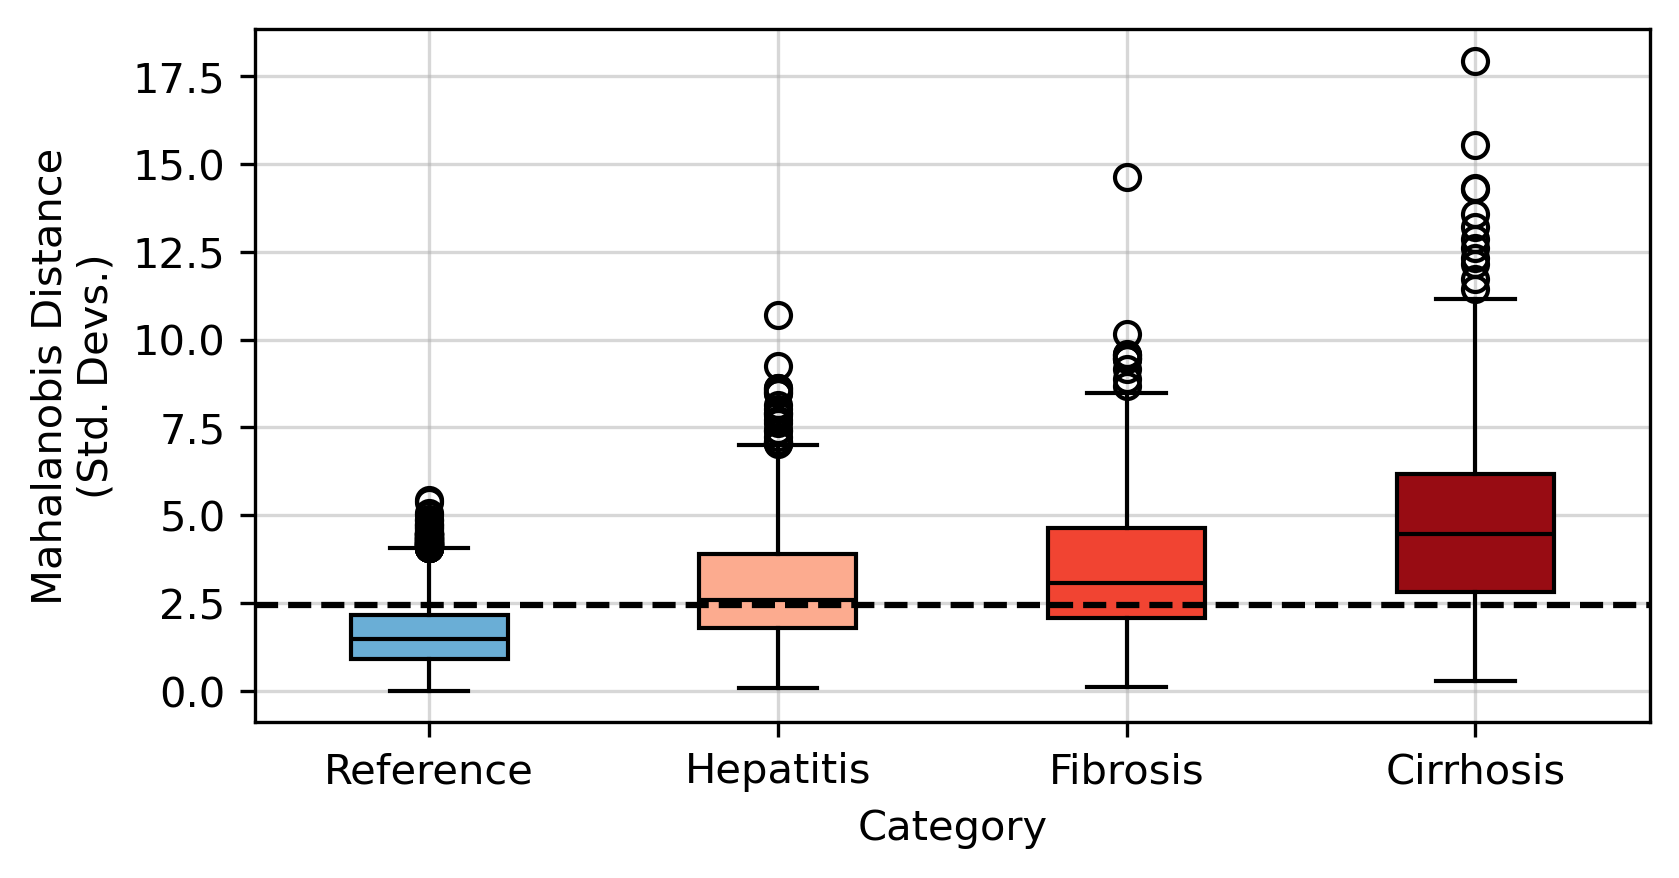

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

keys = ['reference', 'hepatitis', 'fibrosis', 'cirrhosis']
colors = [mpl.colormaps['Blues'](0.5), mpl.colormaps['Reds'](0.3), mpl.colormaps['Reds'](0.6), mpl.colormaps['Reds'](0.9)]
plt.figure(figsize=(6, 3), dpi=300)
bplot = plt.boxplot(
    [pdfs[key] for key in keys], 
    tick_labels=[i.capitalize() for i in keys], 
    medianprops={'color': 'k'},
    patch_artist=True,  # fill with color
    showfliers=True);
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Category')
plt.ylabel('Mahalanobis Distance\n(Std. Devs.)');
plt.axhline(2.448, c='k', linestyle='--');
plt.grid(alpha=0.5);


In [9]:
# # for each prediction
# # measure how many labels changed between RI and model

# changes = []
# for i in results:
#     changes.append(len(np.where(i['model']['labels']!=i['ri']['labels'])[0])/len(i['labels']))
    
# df = pd.DataFrame({
#     'pair': [i['pair'] for i in results],
#     'gender': [i['gender'] for i in results],
#     'coverage_change': [i['model']['coverage']/i['ri']['coverage'] for i in results],
#     'label_changes': changes
# })

# df[df.gender=='M'].sort_values(by='label_changes')
